# Multi Layer Perceptron Notebook

## Description:

This notebook aims to implement a **Multi Layer Perceptron Neural Network** for Forecasting Time Series.

As explained in the **SeriesAnalysis** notebook, this notebook may use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself. The results that will be used are the stationary series obtained from the original series, in order to verify if the **MLP Networks** are capable of forecasting both stationary and non stationary series.

## Notebook Details:

This notebook is divided into 2 main parts: Stationary Series (were differentiated) and Non-stationary Series (original series)

The purpose of crating those parts is to compare with the ARIMA results, that need the series to be stationary.

Each of the parts is divided into subparts as follows:
 - Importing data
 - Splitting Data into a Moving Window approach and into train and test sets
 - Hyperparamter search
 - Training Models with the best hyperparameters
 - Comparing the fitted models with the original series
 - Testing and comparing the models with 1 step forecast
 - Testing and comparing the models with 12 step forecast

### MLP brief introduction

The Multilayer Perceptron Neural Network for Regression is probably the easiest to explain based on the network for Classification: they do the same thing. The only difference is on the output layer itself. While classification networks have its output layer representing the classes/labels, the regressor networks have its output layer representing a the numerical value the is predicted for the next future time step of the time series.

Both the forward propagation in order to predict an output value, and the backpropagation with gradient descent to adjust the weights are computed in the same way for regression and classification, which was presented in class.


In [1]:
#Packages needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neural_network
import sklearn.model_selection # hyperparameter search
import sklearn.metrics
# COMPLETE WITH PACKEGES FOR MLP

np.random.seed(0)

### Some useful functions

In [2]:
#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

#plot two time series
def plot_2_series(real,model,error_value,title,xlabel="Time",ylabel="Values"):
    fig = plt.figure()

    #plotting the series
    plt.plot(real)
    plt.plot(model)

    #Title and lables
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    #Text displaying the RMSE
    text = "RMSE: %.4f" %error_value
    bottom = np.minimum(model.min(),real.min())
    plt.text(x=0,y=bottom,s=text)
    plt.legend(['Original Series','Predicted'])
    plt.show()
    return
    
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series


#normalize time series values into range [0,1]
def normalize(serie):
    values = serie.values[:,0]

    _min = np.min(values)
    _max = np.max(values)
    
    norm_values = (values - _min)/(_max - _min)
    
    newSerie = pd.Series(norm_values)

    return newSerie

#moving_window -> creates a Dataframe test and one for training
def moving_window(serie,lags,split):
    
    data_values = serie.values

    train_values = data_values[:-split].reshape(-1,1)
    test_values = data_values[-split:].reshape(-1,1)

    train_data = np.zeros((train_values.shape[0] - (lags + 1), lags + 2))
    test_data = np.zeros((test_values.shape[0], lags + 2))
    
    
    all_data = np.vstack((train_values,test_values))

    new_data = np.zeros((train_values.shape[0] - (lags + 1) + test_values.shape[0],lags + 2))
    
    
    for i in range(lags + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]

    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]

    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lags,2)] 
    new_train_df = pd.DataFrame(train_data, columns=data_columns,dtype=np.float64)
    new_test_df = pd.DataFrame(test_data, columns=data_columns,dtype=np.float64)

    return new_train_df,new_test_df


#function to split both training and test datasets into X and y, data and targets
def train_test(train_data,test_data):
    X_train = train_data.values[:,:-1]
    y_train = train_data.values[:,-1]

    X_test = test_data.values[:,:-1]
    y_test = test_data.values[:,-1]

    return X_train, y_train, X_test, y_test
    
#Compute some error metrics
def errors(actual, predicted):
    me = np.mean(predicted - actual)  # ME
    mae = sklearn.metrics.median_absolute_error(actual,predicted)    # MAE
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(actual,predicted))  # RMSE
    
    errors = [['ME',me],['MAE',mae],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors


#Funtion that implements h_step forecast
def h_step_forecast(model,lag_values,horizon):
    '''
    model is the clf estimator
    lag_values is a pandas series with the last 12 pass values of the time series
    horizon is a integer witch represent the number of future steps we wish to predict

    How this function works:
        lags values is our x_Train dataset
        we will use the lag values to predict y_t+1
        then we will shift the lag values so that the most recent value is the predicted value y_t+1
        We will repeat this process until the series is full of forecasted values [y_t+1,y_t+2,...,y_t+h]
    '''
    for i in range(horizon):
        y_hat=model.predict(lag_values) # forecasting y_t+1
        for j in range(1,lag_values.shape[1]-2): #shifting every entry to the left 
            for k in range(0,lag_values.shape[0]):
                lag_values[k][j]=lag_values[k][j+1]
        lag_values[0][-1]= y_hat[0] #setting the newest lag_value to be y_t+1, which is the forecasted value
    return y_hat #returning the forecast values that were predicted with early forecasted values

## Importing the series and differenciating in order to get stationary behavior

In [3]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close')

#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff1 = diff(USD_BRL_serie,1)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

## Training and Test Sets

There are 4 important steps that will be/have been done to the time series in order to pass them as input to the MLP.
 - First we differentiate the series in order to obtain a stationary time series. This won't be done in the second part of the notebook.
 - Then, we should normaize the series values so that they are all between [0,1], since this is machine learning good practice.
 - Then we reshape the series into a moving window approach. 
    - We reshape the series into a table in which each row has the l pass values of the series (in our project l is 12), the present value of the series and the next time step value. Our window is, then, as follows: [Y_(t-12),Y_(t-11),...,Y_(t),Y_(t+1)]. The last column of each row will be used as the target for the supervised learning, while the present and pass values will be used as input. The name is moving window because when we go from row *i* to row *i+1* the window of the previous row gets shifted by one unit
 - We must split our series into training anda test data, as usual. We have set the test data to have length 12 since this is the largest horizon we aim to forecast. We also divide the datasets int o inputs **X** and targets **y**. The moving_window() functions divides training and test sets and train_test() splits X and y sets for each dataset.


In [4]:
AmericanAirlines_serie_diff1 = normalize(AmericanAirlines_serie_diff1)
USD_CAD_serie_diff1 = normalize(USD_CAD_serie_diff1)
USD_BRL_serie_diff1 = normalize(USD_BRL_serie_diff1)

In [5]:
split = 12 #number of entries for test
lags = 12 #number of past values that will be used to train the model

train_American_diff1, test_American_diff1 = moving_window(AmericanAirlines_serie_diff1,lags,split)
train_USD_CAD_diff1, test_USD_CAD_diff1 = moving_window(USD_CAD_serie_diff1,lags,split)
train_USD_BRL_diff1, test_USD_BRL_diff1 = moving_window(USD_BRL_serie_diff1,lags,split)

#Let's take a look into the test series
print(test_American_diff1.head())

#Let's just take a look into the dataframe.
train_American_diff1.head()

    y(t-12)   y(t-11)   y(t-10)    y(t-9)    y(t-8)    y(t-7)    y(t-6)  \
0  0.549209  0.549209  0.549209  0.549209  0.576552  0.576552  0.576552   
1  0.549209  0.549209  0.549209  0.576552  0.576552  0.576552  0.576552   
2  0.549209  0.549209  0.576552  0.576552  0.576552  0.576552  0.576552   
3  0.549209  0.576552  0.576552  0.576552  0.576552  0.576552  0.576552   
4  0.576552  0.576552  0.576552  0.576552  0.576552  0.576552  0.576552   

     y(t-5)    y(t-4)    y(t-3)    y(t-2)    y(t-1)      y(t)    y(t+1)  
0  0.576552  0.576552  0.576552  0.576552  0.599207  0.599207  0.599207  
1  0.576552  0.576552  0.576552  0.599207  0.599207  0.599207  0.599207  
2  0.576552  0.576552  0.599207  0.599207  0.599207  0.599207  0.599207  
3  0.576552  0.599207  0.599207  0.599207  0.599207  0.599207  0.599207  
4  0.599207  0.599207  0.599207  0.599207  0.599207  0.599207  0.599207  


,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.537584,0.537584,0.537584,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102
1,0.537584,0.537584,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057
2,0.537584,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057,0.488057
3,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057,0.488057,0.488057
4,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057,0.488057,0.488057,0.488057


#### We need to understand that dataframe.

Each row will be the input of the MLP and the last column *Y(t+1)* is the target, which will be used to learn the right parameters during training.

Note that, in each row, we have a fraction of the series dislocated each time by 1 unit.

The last column *y(t+1)* is our target, so it will be the **y** objects

In [6]:
american_X_train, american_y_train, american_X_test, american_y_test = train_test(train_American_diff1, test_American_diff1) 
USD_CAD_X_train, USD_CAD_y_train, USD_CAD_X_test, USD_CAD_y_test = train_test(train_USD_CAD_diff1, test_USD_CAD_diff1) 
USD_BRL_X_train, USD_BRL_y_train, USD_BRL_X_test, USD_BRL_y_test = train_test(train_USD_BRL_diff1, test_USD_BRL_diff1)

## Implementing MLPs with Hyperparemeter Search

Let's see what each of the hyperparameters mean with both the __[Sklearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)__ and personal coments:
 - hidden_layer_sizes: the number of neurons in each hidden layer. For example, (20,10) means a network with 2 layers, with 20 neurons in the first layer and 10 in the second layer. We have chosen to search only with "simple" architectures, wihtout many layers.
 - activation: type of activation function used in each neuron -> even though in the course slides the linear (identity) activation function is said to be the right one for regression, we have added other options to the search
 - solver: the solver for weight optimization -> it specifies in which way the gradient descent will be computed
 - learning_rate: learning rate schedule for weight optimization -> this defines how quickly the network should update its parameters. If the learning rate is low, learning process is lower but smoothier, if it is high, the learning process is faster but the change of convergence decreases. It may be a good idea to start with a higher rate but decrease it once we start seeing convergence.
	 - ‘constant’ is a constant learning rate given by ‘learning_rate_init’.
	 - ‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early_stopping’ is on, the current learning rate is divided by 5.
 - learning_rate_init: the initial learning rate. If learning_rate is constant, this value will be used during all the training.

   


In [7]:
#Hyperparameters
hidden_layer_sizes = [20,50,100,(20,50),(20,50,100)]
solver = ["adam","sgd","lbfgs"]
random_state = [0]
activation = ["identity","tanh","relu"]
learning_rate = ['constant','adaptive']
learning_rate_init = [0.001,0.01,0.05,0.1]

**Attetion:** Know that the training of these models takes **a lot of time** since we are training a huge number of MLPs with different hyperparameters.

In [8]:
import warnings
warnings.filterwarnings(action='ignore')

clf = sklearn.neural_network.MLPRegressor()
param_grid = {'random_state':random_state,
            'solver':solver,
            'hidden_layer_sizes':hidden_layer_sizes,
            'activation':activation,
            'learning_rate':learning_rate,
            'learning_rate_init':learning_rate_init
            }


clf_grid_American = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(american_X_train,american_y_train)
clf_grid_USD_CAD = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_CAD_X_train,USD_CAD_y_train)
clf_grid_USD_BRL = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_BRL_X_train,USD_BRL_y_train)

In [9]:
print('Best Hyperparameters American' ,clf_grid_American.best_params_)
print('Training Accuracy American',clf_grid_American.score(american_X_train,american_y_train))

print('\nBest Hyperparameters USD/CAD' ,clf_grid_USD_CAD.best_params_)
print('Training Accuracy USD/CAD',clf_grid_USD_CAD.score(USD_CAD_X_train,USD_CAD_y_train))

print('\nBest Hyperparameters USD/CAD' ,clf_grid_USD_BRL.best_params_)
print('Training Accuracy USD/BRL',clf_grid_USD_BRL.score(USD_BRL_X_train,USD_BRL_y_train))

Best Hyperparameters American {'activation': 'identity', 'hidden_layer_sizes': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'random_state': 0, 'solver': 'lbfgs'}
Training Accuracy American 0.7960719178159243

Best Hyperparameters USD/CAD {'activation': 'relu', 'hidden_layer_sizes': (20, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'random_state': 0, 'solver': 'lbfgs'}
Training Accuracy USD/CAD 0.8004337863388389

Best Hyperparameters USD/CAD {'activation': 'identity', 'hidden_layer_sizes': (20, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'random_state': 0, 'solver': 'lbfgs'}
Training Accuracy USD/BRL 0.801278387705314


## Creating the models with the best hyperparameters

In [10]:
clf_American = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=20,
                                activation='identity',
                                solver='lbfgs',
                                learning_rate="constant",
                                learning_rate_init=0.001,
                                random_state=0).fit(american_X_train,american_y_train)


clf_USD_CAD = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20,50),
                                activation='relu',
                                solver='lbfgs',
                                learning_rate="constant",
                                learning_rate_init=0.001,
                                random_state=0).fit(USD_CAD_X_train,USD_CAD_y_train)

clf_USD_BRL = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20,50),
                                activation='identity',
                                solver='lbfgs',
                                learning_rate="constant",
                                learning_rate_init=0.001,
                                random_state=0).fit(USD_BRL_X_train,USD_BRL_y_train)


## Model Training comparison

Here we will use each estimator to view and compare the prediction of the estimator with the original values for training

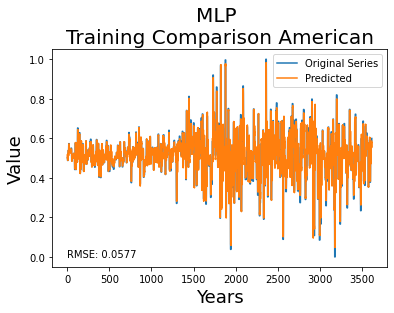

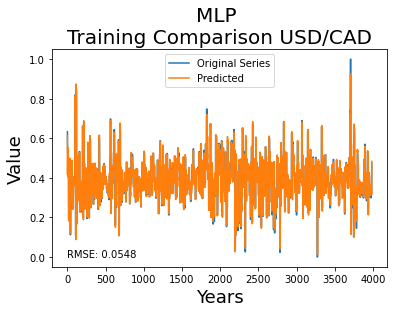

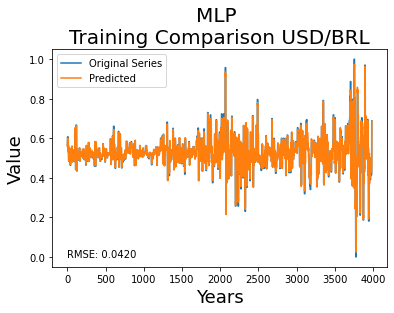


American Model Prediction Errors
  Error     Value
0    ME -0.000079
1   MAE  0.009593
2  RMSE  0.057705

USD/CAD Model Prediction Errors
  Error     Value
0    ME -0.000036
1   MAE  0.009531
2  RMSE  0.054750

USD/BRL Model Prediction Errors
  Error     Value
0    ME  0.000023
1   MAE  0.005538
2  RMSE  0.042002


In [11]:
american_predicted = clf_American.predict(american_X_train)
USD_CAD_predicted = clf_USD_CAD.predict(USD_CAD_X_train)
USD_BRL_predicted = clf_USD_BRL.predict(USD_BRL_X_train)

plot_2_series(real=american_y_train,
            model=american_predicted,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(american_y_train,american_predicted)),
            title='MLP \nTraining Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_train,
            model=USD_CAD_predicted,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_CAD_y_train,USD_CAD_predicted)),
            title='MLP \nTraining Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_train,
            model=USD_BRL_predicted,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_BRL_y_train,USD_BRL_predicted)),
            title='MLP \nTraining Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Prediction Errors")
print(errors(american_y_train,american_predicted))
print("\nUSD/CAD Model Prediction Errors")
print(errors(USD_CAD_y_train,USD_CAD_predicted))
print("\nUSD/BRL Model Prediction Errors")
print(errors(USD_BRL_y_train,USD_BRL_predicted))

## Forecasting 1 step ahead and Plotting

In here we are forecasting only one step ahead, even though it may seem that the forecast horizon is 12.

The horizon is just 1 because in the X_test, each row has the past 12 values, the present value and the one that is "in the future". We are, here, checking how the model is able to forecast the next time step knowing the past 12. In a later section the 12-step forecast is implemented.

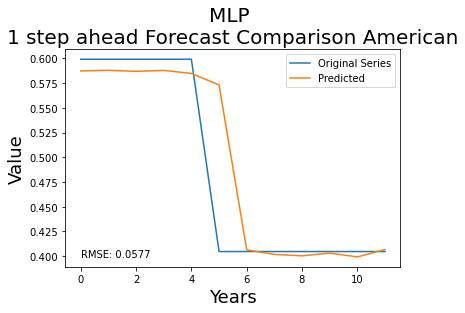

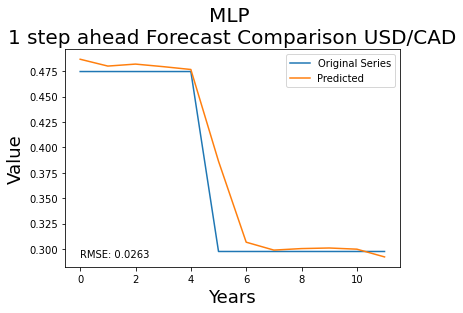

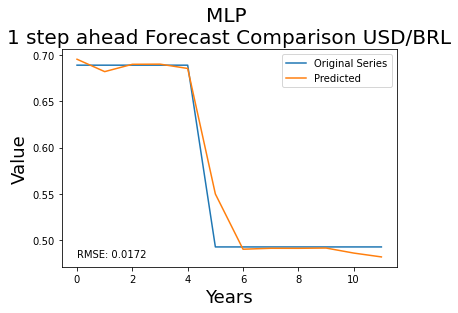


American 1 step Forecast Errors
  Error     Value
0    ME  0.008097
1   MAE  0.008319
2  RMSE  0.049341

USD/CAD 1 step Forecast Errors
  Error     Value
0    ME  0.011178
1   MAE  0.005077
2  RMSE  0.026273

USD/BRL 1 step Forecast Errors
  Error     Value
0    ME  0.002591
1   MAE  0.003006
2  RMSE  0.017176


In [12]:
american_forecast = clf_American.predict(american_X_test)
USD_CAD_forecast = clf_USD_CAD.predict(USD_CAD_X_test)
USD_BRL_forecast = clf_USD_BRL.predict(USD_BRL_X_test)


plot_2_series(real=american_y_test,
            model=american_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(american_y_train,american_predicted)),
            title='MLP \n1 step ahead Forecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_test,
            model=USD_CAD_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_CAD_y_test,USD_CAD_forecast)),
            title='MLP \n1 step ahead Forecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_test,
            model=USD_BRL_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_BRL_y_test,USD_BRL_forecast)),
            title='MLP \n1 step ahead Forecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')

            
print("\nAmerican 1 step Forecast Errors")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD 1 step Forecast Errors")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL 1 step Forecast Errors")
print(errors(USD_BRL_y_test,USD_BRL_forecast))

## 12 step ahead Forecast Comparison

Now, instead of forecasting only the next immediate value for the series, we are implement a multi step (h) forecast.

How the funciton works is explained in the cell where it is implemented, in the beggining of this notebook, so here we present just a brief explanaiton of the idea behind the milti step forecast.

The basic idea is to, first, forecast only the next value of the series. However, when this value is predicted, we feed the serie with it, shifting every entry in the series to the left and adding the new value in the last entry, making the predicted value the most recent one in the time series. Iterating through this process will make the next forecasting respond to the previous one. That is how we accomplish multi step forecasting.

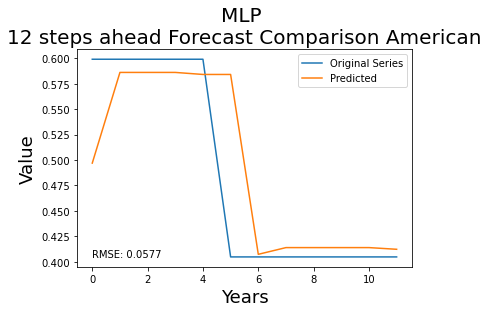

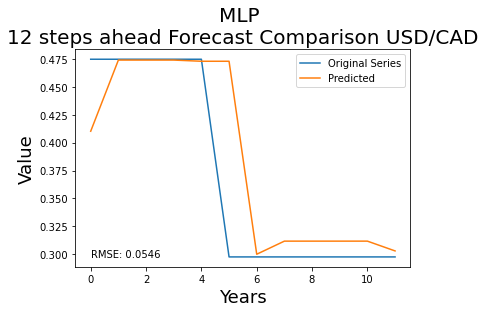

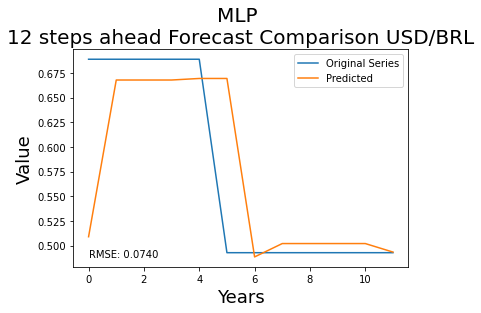


American 12 step Forecast Errors
  Error     Value
0    ME  0.005851
1   MAE  0.011068
2  RMSE  0.060424

USD/CAD 12 step Forecast Errors
  Error     Value
0    ME  0.014254
1   MAE  0.009750
2  RMSE  0.054553

USD/BRL 12 step Forecast Errors
  Error     Value
0    ME -0.004381
1   MAE  0.014377
2  RMSE  0.073976


In [13]:
horizon = 12 #how many steps we want to forecast -> the same size of our test set

american_forecast = h_step_forecast(clf_American,american_X_test,horizon)
USD_CAD_forecast = h_step_forecast(clf_USD_CAD,USD_CAD_X_test,horizon)
USD_BRL_forecast = h_step_forecast(clf_USD_BRL,USD_BRL_X_test,horizon)

plot_2_series(real=american_y_test,
            model=american_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(american_y_train,american_predicted)),
            title='MLP \n12 steps ahead Forecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_test,
            model=USD_CAD_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_CAD_y_test,USD_CAD_forecast)),
            title='MLP \n12 steps ahead Forecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_test,
            model=USD_BRL_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_BRL_y_test,USD_BRL_forecast)),
            title='MLP \n12 steps ahead Forecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican 12 step Forecast Errors")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD 12 step Forecast Errors")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL 12 step Forecast Errors")
print(errors(USD_BRL_y_test,USD_BRL_forecast))

---------------------------------------------------------------------------------------------------------------------------------

## Non-Stationary Series

We must make an observation: a reason for implementing the models on differentiated series was, not only to compare with ARIMA, but also because it is more useful to model *stock return* series than stock prices themselves. By differentiating the series we get, precisely, the returns.

With that being said, the goal to model with non-stationary series is to study each model capacity to forecast that type of time series. One could say that the goal is to check if those models accept more general forms of time series than ARIMA and GARCH models that are implemented only in stationary ones. 

The process from now on will be **exactly** the same, so comments won't be made unless necessary, since everything is already explained in the previous part.

## Training and Test Sets

In [14]:
# #normalizing the series
USD_CAD_serie = normalize(USD_CAD_serie)
USD_BRL_serie = normalize(USD_BRL_serie)
AmericanAirlines_serie = normalize(AmericanAirlines_serie)

split = 12 #number of entries for test
lags = 12 #number of past values that will be used to train the model

train_American, test_American = moving_window(AmericanAirlines_serie,lags,split)
train_USD_CAD, test_USD_CAD = moving_window(USD_CAD_serie,lags,split)
train_USD_BRL, test_USD_BRL = moving_window(USD_BRL_serie,lags,split)

#Let's take a look into the test series
print(test_American.head())

#Let's just take a look into the dataframe.
train_American.head()

    y(t-12)   y(t-11)   y(t-10)    y(t-9)    y(t-8)    y(t-7)    y(t-6)  \
0  0.445311  0.446597  0.447884  0.449171  0.451396  0.453621  0.455847   
1  0.446597  0.447884  0.449171  0.451396  0.453621  0.455847  0.458072   
2  0.447884  0.449171  0.451396  0.453621  0.455847  0.458072  0.460297   
3  0.449171  0.451396  0.453621  0.455847  0.458072  0.460297  0.462522   
4  0.451396  0.453621  0.455847  0.458072  0.460297  0.462522  0.464747   

     y(t-5)    y(t-4)    y(t-3)    y(t-2)    y(t-1)      y(t)    y(t+1)  
0  0.458072  0.460297  0.462522  0.464747  0.467750  0.470752  0.473755  
1  0.460297  0.462522  0.464747  0.467750  0.470752  0.473755  0.476757  
2  0.462522  0.464747  0.467750  0.470752  0.473755  0.476757  0.479760  
3  0.464747  0.467750  0.470752  0.473755  0.476757  0.479760  0.482763  
4  0.467750  0.470752  0.473755  0.476757  0.479760  0.482763  0.485765  


,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.022019,0.022907,0.023794,0.024682,0.025570,0.026458,0.027346,0.028234,0.027904,0.027574,0.027244,0.026915,0.026585,0.026255
1,0.022907,0.023794,0.024682,0.025570,0.026458,0.027346,0.028234,0.027904,0.027574,0.027244,0.026915,0.026585,0.026255,0.025925
2,0.023794,0.024682,0.025570,0.026458,0.027346,0.028234,0.027904,0.027574,0.027244,0.026915,0.026585,0.026255,0.025925,0.025114
3,0.024682,0.025570,0.026458,0.027346,0.028234,0.027904,0.027574,0.027244,0.026915,0.026585,0.026255,0.025925,0.025114,0.024302
4,0.025570,0.026458,0.027346,0.028234,0.027904,0.027574,0.027244,0.026915,0.026585,0.026255,0.025925,0.025114,0.024302,0.023490


### Splitting into X and y

In [15]:
american_X_train, american_y_train, american_X_test, american_y_test = train_test(train_American, test_American) 
USD_CAD_X_train, USD_CAD_y_train, USD_CAD_X_test, USD_CAD_y_test = train_test(train_USD_CAD, test_USD_CAD) 
USD_BRL_X_train, USD_BRL_y_train, USD_BRL_X_test, USD_BRL_y_test = train_test(train_USD_BRL, test_USD_BRL) 

## Implementing MLPs with Hyperparemeter Search

In [16]:
#Hyperparameters
hidden_layer_sizes = [20,50,100,(20,50),(20,50,100)]
solver = ["adam","sgd","lbfgs"]
random_state = [0]
activation = ["identity","tanh","relu"]
learning_rate = ['constant','adaptive']
learning_rate_init = [0.001,0.01,0.05,0.1]

Know that the training of these models takes **a lot of time** since we are training a huge number of MLPs with different hyperparameters.

In [17]:
import warnings
warnings.filterwarnings(action='ignore')

clf = sklearn.neural_network.MLPRegressor()
param_grid = {'random_state':random_state,
            'solver':solver,
            'hidden_layer_sizes':hidden_layer_sizes,
            'activation':activation,
            'learning_rate':learning_rate,
            'learning_rate_init':learning_rate_init
            }


clf_grid_American = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(american_X_train,american_y_train)
print("Done 1")
clf_grid_USD_CAD = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_CAD_X_train,USD_CAD_y_train)
print("Done 2")
clf_grid_USD_BRL = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_BRL_X_train,USD_BRL_y_train)
print("Done 3")

Done 1
Done 2
Done 3


In [18]:
print('Best Hyperparameters American' ,clf_grid_American.best_params_)
print('Training Accuracy American',clf_grid_American.score(american_X_train,american_y_train))

print('\nBest Hyperparameters USD/CAD' ,clf_grid_USD_CAD.best_params_)
print('Training Accuracy USD/CAD',clf_grid_USD_CAD.score(USD_CAD_X_train,USD_CAD_y_train))

print('\nBest Hyperparameters USD/CAD' ,clf_grid_USD_BRL.best_params_)
print('Training Accuracy USD/BRL',clf_grid_USD_BRL.score(USD_BRL_X_train,USD_BRL_y_train))

Best Hyperparameters American {'activation': 'identity', 'hidden_layer_sizes': 50, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'random_state': 0, 'solver': 'lbfgs'}
Training Accuracy American 0.9987310566184852

Best Hyperparameters USD/CAD {'activation': 'identity', 'hidden_layer_sizes': 50, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'random_state': 0, 'solver': 'lbfgs'}
Training Accuracy USD/CAD 0.9990894417189058

Best Hyperparameters USD/CAD {'activation': 'identity', 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'random_state': 0, 'solver': 'sgd'}
Training Accuracy USD/BRL 0.9992784122806223


## Creating the models with the best hyperparameters

In [19]:
clf_American = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=50,
                                activation='identity',
                                solver='lbfgs',
                                learning_rate="constant",
                                learning_rate_init=0.001,
                                random_state=0).fit(american_X_train,american_y_train)


clf_USD_CAD = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=50,
                                activation='identity',
                                solver='lbfgs',
                                learning_rate="constant",
                                learning_rate_init=0.001,
                                random_state=0).fit(USD_CAD_X_train,USD_CAD_y_train)

clf_USD_BRL = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=50,
                                activation='identity',
                                solver='sgd',
                                learning_rate="adaptive",
                                learning_rate_init=0.1,
                                random_state=0).fit(USD_BRL_X_train,USD_BRL_y_train)


## Model Training comparison

Here we will use each estimator to view and compare the prediction of the estimator with the original values for training

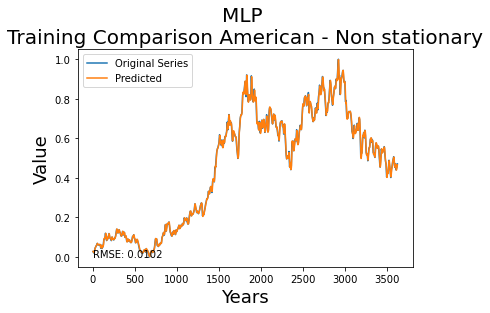

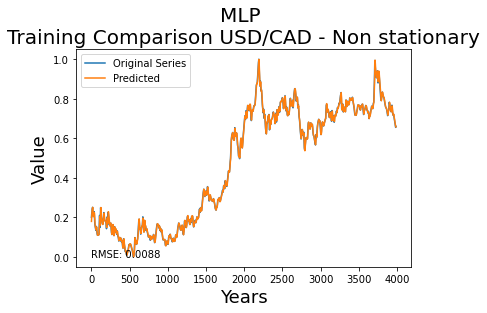

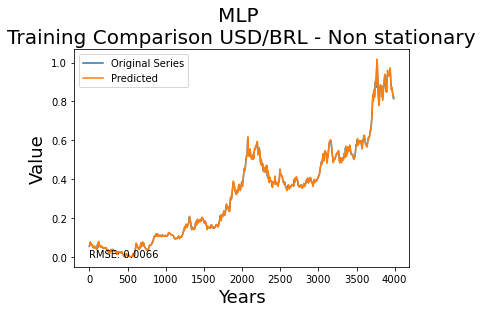


American Model Prediction Errors - Non stationary
  Error     Value
0    ME -0.000020
1   MAE  0.004669
2  RMSE  0.010226

USD/CAD Model Prediction Errors - Non stationary
  Error     Value
0    ME -0.000031
1   MAE  0.005122
2  RMSE  0.008815

USD/BRL Model Prediction Errors - Non stationary
  Error     Value
0    ME -0.000006
1   MAE  0.002674
2  RMSE  0.006582


In [20]:
american_predicted = clf_American.predict(american_X_train)
USD_CAD_predicted = clf_USD_CAD.predict(USD_CAD_X_train)
USD_BRL_predicted = clf_USD_BRL.predict(USD_BRL_X_train)

plot_2_series(real=american_y_train,
            model=american_predicted,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(american_y_train,american_predicted)),
            title='MLP \nTraining Comparison American - Non stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_train,
            model=USD_CAD_predicted,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_CAD_y_train,USD_CAD_predicted)),
            title='MLP \nTraining Comparison USD/CAD - Non stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_train,
            model=USD_BRL_predicted,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_BRL_y_train,USD_BRL_predicted)),
            title='MLP \nTraining Comparison USD/BRL - Non stationary',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Prediction Errors - Non stationary")
print(errors(american_y_train,american_predicted))
print("\nUSD/CAD Model Prediction Errors - Non stationary")
print(errors(USD_CAD_y_train,USD_CAD_predicted))
print("\nUSD/BRL Model Prediction Errors - Non stationary")
print(errors(USD_BRL_y_train,USD_BRL_predicted))

## 1 step ahead Forecast Comparison

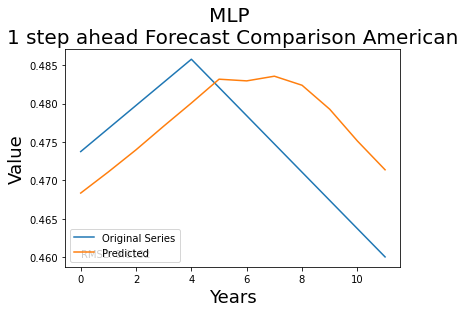

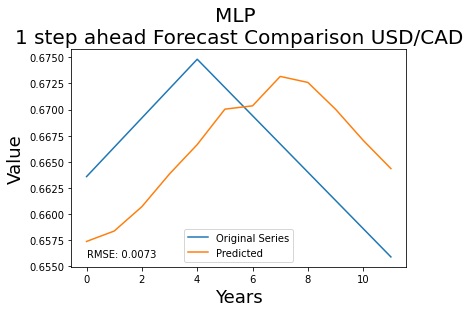

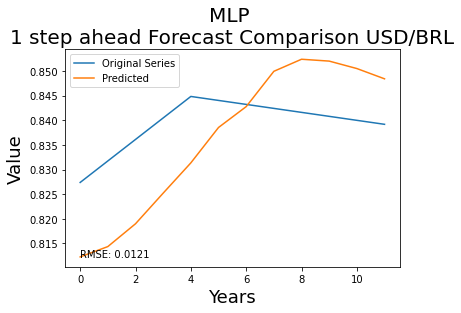


American 1 step Forecast Errors - Non stationary
  Error     Value
0    ME  0.002677
1   MAE  0.005736
2  RMSE  0.008091

USD/CAD 1 step Forecast Errors - Non stationary
  Error     Value
0    ME  0.000042
1   MAE  0.008166
2  RMSE  0.007349

USD/BRL 1 step Forecast Errors - Non stationary
  Error     Value
0    ME -0.002918
1   MAE  0.010997
2  RMSE  0.012119


In [21]:
american_forecast = clf_American.predict(american_X_test)
USD_CAD_forecast = clf_USD_CAD.predict(USD_CAD_X_test)
USD_BRL_forecast = clf_USD_BRL.predict(USD_BRL_X_test)

plot_2_series(real=american_y_test,
            model=american_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(american_y_train,american_predicted)),
            title='MLP \n1 step ahead Forecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_test,
            model=USD_CAD_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_CAD_y_test,USD_CAD_forecast)),
            title='MLP \n1 step ahead Forecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_test,
            model=USD_BRL_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_BRL_y_test,USD_BRL_forecast)),
            title='MLP \n1 step ahead Forecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')

            
print("\nAmerican 1 step Forecast Errors - Non stationary")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD 1 step Forecast Errors - Non stationary")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL 1 step Forecast Errors - Non stationary")
print(errors(USD_BRL_y_test,USD_BRL_forecast))

## 12 step ahead Forecast Comparison

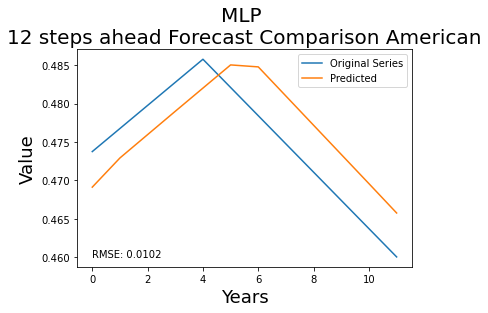

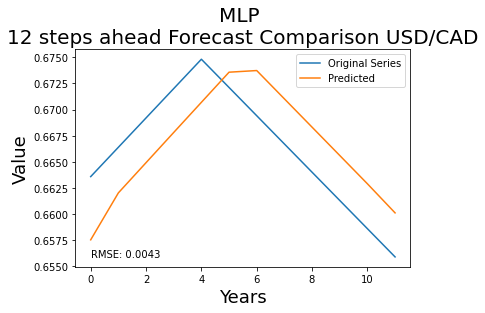

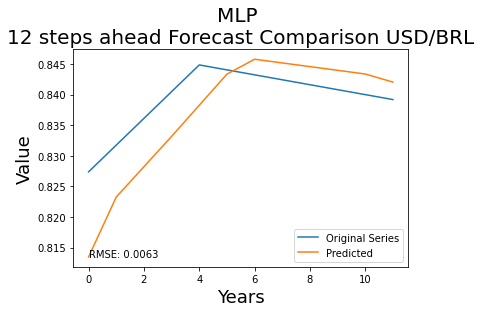


American 12 step Forecast Errors - Non-stationary
  Error     Value
0    ME  0.001616
1   MAE  0.005169
2  RMSE  0.005053

USD/CAD 12 step Forecast Error - Non-stationarys
  Error     Value
0    ME  0.000351
1   MAE  0.004301
2  RMSE  0.004296

USD/BRL 12 step Forecast Errors - Non-stationary
  Error     Value
0    ME -0.002268
1   MAE  0.003264
2  RMSE  0.006301


In [22]:
horizon = 12 #how many steps we want to forecast -> the same size of our test set

american_forecast = h_step_forecast(clf_American,american_X_test,horizon)
USD_CAD_forecast = h_step_forecast(clf_USD_CAD,USD_CAD_X_test,horizon)
USD_BRL_forecast = h_step_forecast(clf_USD_BRL,USD_BRL_X_test,horizon)

plot_2_series(real=american_y_test,
            model=american_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(american_y_train,american_predicted)),
            title='MLP \n12 steps ahead Forecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_test,
            model=USD_CAD_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_CAD_y_test,USD_CAD_forecast)),
            title='MLP \n12 steps ahead Forecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_test,
            model=USD_BRL_forecast,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_BRL_y_test,USD_BRL_forecast)),
            title='MLP \n12 steps ahead Forecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican 12 step Forecast Errors - Non-stationary")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD 12 step Forecast Error - Non-stationarys")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL 12 step Forecast Errors - Non-stationary")
print(errors(USD_BRL_y_test,USD_BRL_forecast))

